In [7]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import boto3
import pathlib
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import seaborn as sns

## Download images model

In [2]:
boto3.setup_default_session(profile_name="faculdade") #TODO: remove in production
s3 = boto3.client('s3')
bucket_staged = 'tcc-dev-staged-bucket'
bucket_model = 'tcc-dev-saved-model-bucket'

paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket='tcc-dev-staged-bucket')

files_s3 = []
for page in pages:
    for obj in page['Contents']:
        files_s3.append(obj['Key'])

files_acne = [f for f in files_s3 if str(f).startswith('Acne/') and f != 'Acne/']
files_no_acne = [f for f in files_s3 if str(f).startswith('SemAcne/') and f != 'SemAcne/']
folders_imgs = ['Acne', 'SemAcne']

def download_list_files_s3(files: list, bucket_name: str, save_dir=''):
    save_dir = os.path.join('svm', save_dir)
    if not os.path.exists(save_dir):
        pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    for f in files:
        print(f'Downloading file={f}')
        s3.download_file(bucket_name, f, os.path.join(save_dir, os.path.split(f)[-1]))

download_list_files_s3(files_acne, bucket_staged, folders_imgs[0])
download_list_files_s3(files_no_acne, bucket_staged, folders_imgs[1])

In [6]:
def load_data(data_dir, img_size=(128, 128)):
    labels = []
    features = []
    for label in ['Acne', 'SemAcne']:
        folder = os.path.join(data_dir, label)
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = imread(img_path)
            if img.ndim == 3:
                img = rgb2gray(img)
            img_resized = resize(img, img_size)
            hog_features = hog(img_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
            features.append(hog_features)
            labels.append(0 if label == 'SemAcne' else 1)
    return np.array(features), np.array(labels)

# Carregar dados
print('Training model...')
data_dir = 'svm'
X, y = load_data(data_dir)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar um classificador SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = clf.predict(X_test)

# Calcular métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Imprimir métricas
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')

Training model...
Accuracy: 96.58%
F1 Score: 0.98
Confusion Matrix:
[[ 37  10]
 [  4 358]]
Recall: 0.99
Precision: 0.97


| TP | FN |

| FP | TN |

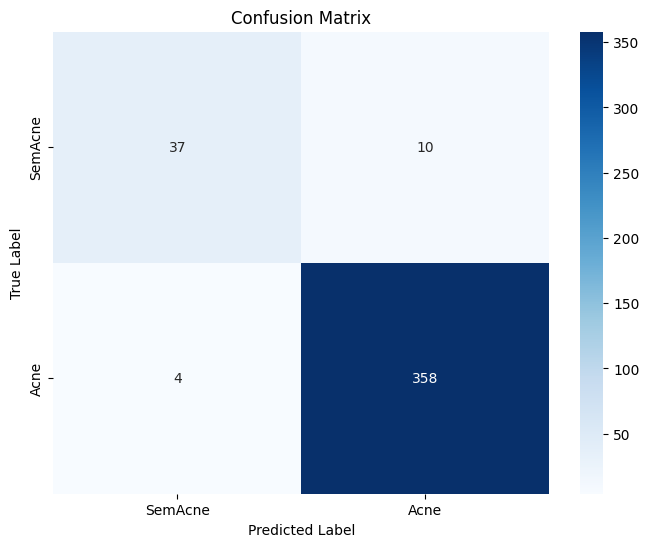

In [8]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['SemAcne', 'Acne'], yticklabels=['SemAcne', 'Acne'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()